In [1]:
import os
import ast
from datetime import datetime
from typing import List, Generator
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

import numpy as np
import pandas as pd

import pywt
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import indexable, _num_samples

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1.nn.rnn_cell import LSTMCell
from tensorflow.compat.v1.nn import static_rnn
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


# 0.utils

## 0.1 load data

In [ ]:
def load_stockindex_(indexname=None,start_='2014-12-31',end_='2021-01-01'):
  # note:
  stockindex = yf.Ticker(indexname)
  stockindex_hist = stockindex.history(start=start_,end=end_)
  stockindex_hist.index=pd.to_datetime(stockindex_hist.index.date)
  stockindex_hist.index = pd.DatetimeIndex(stockindex_hist.index).to_period('D')
  return stockindex_hist[['Close']]

In [ ]:
def load_sentiment_(start_='2014-12-31',end_='2020-12-31'):
  # note:
  filename = "../data/df_news_sentiment_LMDictionary.csv"
  df=pd.read_csv(filename).drop('Unnamed: 0',axis=1)
  df=df[(df['timestamp']>=start_)&(df['timestamp']<=end_)]

  df.index=df['timestamp']
  df=df.drop('timestamp',axis=1)
  df.index=pd.to_datetime(df.index)
  df.index = pd.DatetimeIndex(df.index).to_period('D')

  for col in df.columns:
    df[col]=df[col]/df[col].max()

  return df

In [ ]:
def load_CLS_(dim_emb=None,start_='2014-12-31',end_='2020-12-31'):
  # note:
  pca=PCA(n_components=dim_emb)
  
  #----------------------------------
  path = '../data/CLS/CLSv2/train_CLS_v2_dict.txt'
  with open(path, 'r') as j:
    contents = ast.literal_eval(j.read())
  df_train = pd.DataFrame(contents).T
  path = '../data/CLS/CLSv2/valid_CLS_v2_dict.txt'
  with open(path, 'r') as j:
    contents = ast.literal_eval(j.read())
  df_vali = pd.DataFrame(contents).T
  df1=pd.concat([df_train,df_vali],axis=0)[:-1] # 2019-12-31 in vali and test, drop it in vali

  df1_tmp=pd.DataFrame()
  df1_tmp['Date']=df1.index
  df1_tmp[['p'+str(x) for x in range(dim_emb)]]=pca.fit_transform(np.array(df1))

  #------------------------------------
  path = '/data/CLS/CLSv2/test_CLS_v2_dict.txt'
  with open(path, 'r') as j:
    contents = ast.literal_eval(j.read())
  df2 = pd.DataFrame(contents).T

  df2_tmp=pd.DataFrame()
  df2_tmp['Date']=df2.index
  df2_tmp[['p'+str(x) for x in range(dim_emb)]]=pca.transform(np.array(df2))
   
  #-------------------------------------
  df=pd.concat([df1_tmp,df2_tmp],axis=0)
  df=df[(df['Date']>=start_)&(df['Date']<=end_)]

  df.index=df['Date']
  df.index=pd.to_datetime(df.index)
  df.index = pd.DatetimeIndex(df.index).to_period('D')
  df=df.drop(['Date'],axis=1)
  return df

## 0.2 prepare data

In [ ]:
def logreturn_(arr_):
  # note:
  logreturn = np.diff(np.log(arr_))
  return logreturn

In [ ]:
def generate_samples(index_name='^GSPC',emb_name='CLS',
                     dim_days=10,dim_emb=4,dim_CLSemb=9):

  #===================================================
  data=load_stockindex_(index_name)

  arr=np.array(data).reshape(-1)
  arr_logreturn=logreturn_(arr)

  if emb_name=='CLS':
    arr_emb=np.array(pd.merge(data, load_CLS_(dim_CLSemb), 
                     how='left',left_index=True, right_index=True).drop('Close',axis=1))[1:]
  else:
    arr_emb=np.array(pd.merge(data, load_sentiment_(), 
                     how='left',left_index=True, right_index=True).drop('Close',axis=1))[1:]
  
  num_test=len(data[data.index>='2020-01-01'])
  #print(arr_logreturn.shape, arr_emb.shape, num_test)


  #===================================================
  start_index=0
  end_index=dim_days
  x1_set=[]
  x2_set=[]
  y_set=[]
  
  #-------------------------------------
  for i in range(len(arr_logreturn)-dim_days):
    x1_=arr_logreturn[start_index:end_index]
    widths=np.arange(1, dim_emb+1)
    x1=signal.cwt(data=x1_, wavelet=signal.ricker, widths=widths).T

    x2=arr_emb[start_index:end_index]

    y=arr_logreturn[end_index]

    x1_set.append(x1)
    x2_set.append(x2)
    y_set.append(y)
    
    start_index+=1
    end_index+=1

  #-----------------------------------
  x1_set,x2_set,y_set=np.array(x1_set),np.array(x2_set),np.array(y_set)
  holdout_x1,test_x1=x1_set[:-num_test],x1_set[-num_test:]
  holdout_x2,test_x2=x2_set[:-num_test],x2_set[-num_test:]
  holdout_y,test_y=y_set[:-num_test],y_set[-num_test:]

  print('holdout_x1 shape=',holdout_x1.shape,'   test_x1 shape=',test_x1.shape)
  print('holdout_x2 shape=',holdout_x2.shape,'   test_x2 shape=',test_x2.shape)
  print('holdout_y shape=',holdout_y.shape,'   test_y shape=',test_y.shape)
  return holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y

In [ ]:
class MonteCarloCV(_BaseKFold):

    def __init__(self,
                 n_splits: int,
                 train_size: float,
                 test_size: float,
                 gap: int = 0,
                 seed: int= 42):
        """
        Monte Carlo Cross-Validation

        Holdout applied in multiple testing periods
        Testing origin (time-step where testing begins) is randomly chosen according to a monte carlo simulation

        :param n_splits: (int) Number of monte carlo repetitions in the procedure
        :param train_size: (float) Train size, in terms of ratio of the total length of the series
        :param test_size: (float) Test size, in terms of ratio of the total length of the series
        :param gap: (int) Number of samples to exclude from the end of each train set before the test set.
        :param seed: (int) Added to ensure reproducibility in the random selection of folds
        """

        self.n_splits = n_splits
        self.n_samples = -1
        self.gap = gap
        self.train_size = train_size
        self.test_size = test_size
        self.train_n_samples = 0
        self.test_n_samples = 0
        # add a seed parameter
        self.seed = seed

        self.mc_origins = []

    def split(self, X, y=None, groups=None) -> Generator:
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        # set the seed
        np.random.seed(self.seed)

        X, y, groups = indexable(X, y, groups)
        self.n_samples = _num_samples(X)

        self.train_n_samples = int(self.n_samples * self.train_size) - 1
        self.test_n_samples = int(self.n_samples * self.test_size) - 1

        # Make sure we have enough samples for the given split parameters
        if self.n_splits > self.n_samples:
            raise ValueError(
                f'Cannot have number of folds={self.n_splits} greater'
                f' than the number of samples={self.n_samples}.'
            )
        if self.train_n_samples - self.gap <= 0:
            raise ValueError(
                f'The gap={self.gap} is too big for number of training samples'
                f'={self.train_n_samples} with testing samples={self.test_n_samples} and gap={self.gap}.'
            )

        indices = np.arange(self.n_samples)

        selection_range = np.arange(self.train_n_samples + 1, self.n_samples - self.test_n_samples - 1)

        self.mc_origins = \
            np.random.choice(a=selection_range,
                             size=self.n_splits,
                             replace=True)

        for origin in self.mc_origins:
            if self.gap > 0:
                train_end = origin - self.gap + 1
            else:
                train_end = origin - self.gap
            train_start = origin - self.train_n_samples - 1

            test_end = origin + self.test_n_samples

            yield (
                indices[train_start:train_end],
                indices[origin:test_end],
            )

    def get_origins(self) -> List[int]:
        return self.mc_origins

In [ ]:
def cv_index_dict_(holdout_y):
  cv_index_dict={}
  mccv = MonteCarloCV(n_splits=10,train_size=0.6,test_size=0.2,gap=0,seed=42) 
  for fold, (train_index, test_index) in enumerate(mccv.split(holdout_y)):
    cv_index_dict[fold]=[train_index,test_index]
  return cv_index_dict

## 0.3 model

In [ ]:
def rnn_TUN_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,cv_index_dict,
             dim_days=10,dim_emb=4,dim_CLSemb=9,dim_lstm=2,dim_fully=4,
             epoch_num=10,lr=0.0001):
  
  valiloss_record=[]
  testpred_record=[]

  for key in cv_index_dict:
    train_index=cv_index_dict[key][0]
    train_x1=holdout_x1[train_index]
    train_x2=holdout_x2[train_index]
    train_y=holdout_y[train_index]

    vali_index=cv_index_dict[key][1]
    vali_x1=holdout_x1[vali_index]
    vali_x2=holdout_x2[vali_index]
    vali_y=holdout_y[vali_index]

    tf.keras.backend.clear_session()
    #1.define model's variables--------------------------------
    ## 1.1 placeholder
    ph_kp=tf.placeholder(tf.float32)
    ph_x1=tf.placeholder(tf.float32,shape=[None,dim_days,dim_emb])
    ph_x2=tf.placeholder(tf.float32,shape=[None,dim_days,dim_CLSemb])
    ph_y=tf.placeholder(tf.float32,shape=[None,1])
    ## 1.2 lstm cell
    cell1=LSTMCell(dim_lstm) 
    cell2=LSTMCell(dim_lstm) 
    cell3=LSTMCell(dim_lstm)
    ## 1.3 attention mechanism
    w_omega=tf.Variable(tf.random_normal([dim_lstm*2,2],stddev=0.1))
    b_omega=tf.Variable(tf.random_normal([2,],stddev=0.1))
    u_omega=tf.Variable(tf.random_normal([2,],stddev=0.1))
    ## 1.4 fully connected 
    ww=tf.Variable(tf.truncated_normal([dim_lstm*2+dim_days,dim_fully],stddev=0.1))
    bb=tf.Variable(tf.constant(0.0,shape=[dim_fully,]))
    w=tf.Variable(tf.truncated_normal([dim_fully,1],stddev=0.1))
    bias=tf.Variable(tf.constant(0.0,shape=[1,])) 
    
    #2.define model's architecture------------------------------
    ##2.1 Bi-lstm part
    rnn_outputs_temp,useless=bi_rnn(cell1,cell2,inputs=ph_x1,sequence_length=[dim_days]*1,dtype=tf.float32,scope='x1')
    rnn_outputs=tf.concat(rnn_outputs_temp,2)
    ##2.2 attention part
    v=tf.tanh(tf.tensordot(rnn_outputs,w_omega,axes=1)+b_omega)  #(B,T,D)*(D,A)=(B,T,A)  D=2*d!!!
    vu=tf.tensordot(v,u_omega,axes=1)                            #(B,T,A)*(A,)=(B,T)
    alphas=tf.nn.softmax(vu)
    attention_output=tf.reduce_sum(rnn_outputs*tf.expand_dims(alphas,-1),1)
    drop=tf.nn.dropout(attention_output,ph_kp)
    ##2.3 concatenate part
    CLS_rnn_,_=static_rnn(cell3, tf.unstack(ph_x2, dim_days, 1), dtype=tf.float32)
    CLS_rnn=tf.reshape(tf.reduce_mean(CLS_rnn_,axis=2),[1,dim_days])
    fully_con_=tf.concat([drop,CLS_rnn],axis=1)
    fully_con=tf.nn.relu(tf.nn.xw_plus_b(fully_con_,ww,bb)) ## try leaky-relu, relu, not work
    #fully_con=tf.nn.leaky_relu(tf.nn.xw_plus_b(fully_con_,ww,bb))
    ##2.3 output part
    y_hat=tf.nn.xw_plus_b(fully_con,w,bias) 
    ##3.loss & optimazation method------------------------------
    loss=tf.sqrt(tf.reduce_mean((ph_y-y_hat)**2))  
    optimizer=tf.train.AdamOptimizer(learning_rate=lr,beta1=0.99)  ##try SGD optimizer, not work
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate=lr)
    train_step=optimizer.minimize(loss)
    sess=tf.Session()
    sess.run(tf.global_variables_initializer()) 
    
    #4.model training-------------------------------------------
    loss_epoch=[]
    for epoch in range(epoch_num):

      loss_tmp=0
      for i in range(len(vali_y)):   
        x1=vali_x1[i].reshape(1,dim_days,dim_emb)  
        x2=vali_x2[i].reshape(1,dim_days,dim_CLSemb)
        y=vali_y[i].reshape(-1,1)
        loss_tmp+=sess.run(loss,feed_dict={ph_x1:x1,ph_x2:x2,ph_y:y,ph_kp:1.0})   
      loss_epoch.append(1.*loss_tmp/len(vali_y))

      for i in range(len(train_y)):
        x1=train_x1[i].reshape(1,dim_days,dim_emb)
        x2=train_x2[i].reshape(1,dim_days,dim_CLSemb)
        y=train_y[i].reshape(-1,1)
        sess.run(train_step,feed_dict={ph_x1:x1,ph_x2:x2,ph_y:y,ph_kp:0.95})
    valiloss_record.append(loss_epoch)
    print('validation',key,' epoch loss=',np.round(valiloss_record[key],6))

    #5.predict--------------------------------------------------
    pred_list=[]
    for i in range(len(test_y)):   
      x1=test_x1[i].reshape(1,dim_days,dim_emb)  
      x2=test_x2[i].reshape(1,dim_days,dim_CLSemb)
      pred=sess.run(y_hat,feed_dict={ph_x1:x1,ph_x2:x2,ph_kp:1.0})   
      pred_list.append(pred[0][0])    
    testpred_record.append(pred_list)

  return valiloss_record, testpred_record

In [ ]:
def rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
         dim_days=10,dim_emb=4,dim_CLSemb=9,dim_lstm=2,dim_fully=4,
         epoch_num=10,lr=0.0016):
 
    tf.keras.backend.clear_session()
    #1.define model's variables--------------------------------
    ## 1.1 placeholder
    ph_kp=tf.placeholder(tf.float32)
    ph_x1=tf.placeholder(tf.float32,shape=[None,dim_days,dim_emb])
    ph_x2=tf.placeholder(tf.float32,shape=[None,dim_days,dim_CLSemb])
    ph_y=tf.placeholder(tf.float32,shape=[None,1])
    ## 1.2 lstm cell
    cell1=LSTMCell(dim_lstm) 
    cell2=LSTMCell(dim_lstm) 
    cell3=LSTMCell(dim_lstm)
    ## 1.3 attention mechanism
    w_omega=tf.Variable(tf.random_normal([dim_lstm*2,2],stddev=0.1))
    b_omega=tf.Variable(tf.random_normal([2,],stddev=0.1))
    u_omega=tf.Variable(tf.random_normal([2,],stddev=0.1))
    ## 1.4 fully connected 
    ww=tf.Variable(tf.truncated_normal([dim_lstm*2+dim_days,dim_fully],stddev=0.1))
    bb=tf.Variable(tf.constant(0.0,shape=[dim_fully,]))
    w=tf.Variable(tf.truncated_normal([dim_fully,1],stddev=0.1))
    bias=tf.Variable(tf.constant(0.0,shape=[1,])) 
    
    #2.define model's architecture------------------------------
    ##2.1 Bi-lstm part
    rnn_outputs_temp,useless=bi_rnn(cell1,cell2,inputs=ph_x1,sequence_length=[dim_days]*1,dtype=tf.float32,scope='x1')
    rnn_outputs=tf.concat(rnn_outputs_temp,2)
    ##2.2 attention part
    v=tf.tanh(tf.tensordot(rnn_outputs,w_omega,axes=1)+b_omega)  #(B,T,D)*(D,A)=(B,T,A)  D=2*d!!!
    vu=tf.tensordot(v,u_omega,axes=1)                            #(B,T,A)*(A,)=(B,T)
    alphas=tf.nn.softmax(vu)
    attention_output=tf.reduce_sum(rnn_outputs*tf.expand_dims(alphas,-1),1)
    drop=tf.nn.dropout(attention_output,ph_kp)
    ##2.3 concatenate part
    CLS_rnn_,_=static_rnn(cell3, tf.unstack(ph_x2, dim_days, 1), dtype=tf.float32)
    CLS_rnn=tf.reshape(tf.reduce_mean(CLS_rnn_,axis=2),[1,dim_days])
    fully_con_=tf.concat([drop,CLS_rnn],axis=1)
    fully_con=tf.nn.relu(tf.nn.xw_plus_b(fully_con_,ww,bb))
    ##2.3 output part
    y_hat=tf.nn.xw_plus_b(fully_con,w,bias)
    ##3.loss & optimazation method------------------------------
    loss=tf.sqrt(tf.reduce_mean((ph_y-y_hat)**2))
    optimizer=tf.train.AdamOptimizer(learning_rate=lr,beta1=0.99)
    train_step=optimizer.minimize(loss)
    sess=tf.Session()
    sess.run(tf.global_variables_initializer()) 
    
    #4.model training-------------------------------------------
    for epoch in range(epoch_num):
        for i in range(len(holdout_y)):
            x1=holdout_x1[i].reshape(1,dim_days,dim_emb)
            x2=holdout_x2[i].reshape(1,dim_days,dim_CLSemb)
            y=holdout_y[i].reshape(-1,1)
            sess.run(train_step,feed_dict={ph_x1:x1,ph_x2:x2,ph_y:y,ph_kp:0.95})

    #5.predict--------------------------------------------------
    true_list=test_y
    pred_list=[]
    for i in range(len(test_y)):   
        x1=test_x1[i].reshape(1,dim_days,dim_emb)  
        x2=test_x2[i].reshape(1,dim_days,dim_CLSemb)
        pred=sess.run(y_hat,feed_dict={ph_x1:x1,ph_x2:x2,ph_kp:1.0})   
        pred_list.append(pred[0][0])    

    return pred_list, true_list

In [ ]:
def subrnn_(train_x,test_x,train_y,test_y,
            epoch_num=10,
            dim_days=10,dim_emb=4,dim_lstm=2):
 
    tf.keras.backend.clear_session()
    #1.define model's variables--------------------------------
    ## 1.1 placeholder
    ph_kp=tf.placeholder(tf.float32)
    ph_x=tf.placeholder(tf.float32,shape=[None,dim_days,dim_emb])
    ph_y=tf.placeholder(tf.float32,shape=[None,1])
    ## 1.2 lstm cell
    cell1=LSTMCell(dim_lstm) 
    cell2=LSTMCell(dim_lstm) 
    ## 1.3 attention mechanism
    w_omega=tf.Variable(tf.random_normal([dim_lstm*2,2],stddev=0.1))
    b_omega=tf.Variable(tf.random_normal([2,],stddev=0.1))
    u_omega=tf.Variable(tf.random_normal([2,],stddev=0.1))
    ## 1.4 fully connected 
    w=tf.Variable(tf.truncated_normal([dim_lstm*2,1],stddev=0.1))
    bias=tf.Variable(tf.constant(0.0,shape=[1,])) 

    #2.define model's architecture------------------------------
    ##2.1 Bi-lstm part
    rnn_outputs_temp,useless=bi_rnn(cell1,cell2,inputs=ph_x,sequence_length=[dim_days]*1,dtype=tf.float32)
    rnn_outputs=tf.concat(rnn_outputs_temp,2)
    ##2.2 attention part
    v=tf.tanh(tf.tensordot(rnn_outputs,w_omega,axes=1)+b_omega)  #(B,T,D)*(D,A)=(B,T,A)  D=2*d!!!
    vu=tf.tensordot(v,u_omega,axes=1)                            #(B,T,A)*(A,)=(B,T)
    alphas=tf.nn.softmax(vu)
    attention_output=tf.reduce_sum(rnn_outputs*tf.expand_dims(alphas,-1),1)
    drop=tf.nn.dropout(attention_output,ph_kp)
    ##2.3 output part
    y_hat=tf.nn.xw_plus_b(drop,w,bias)

    ##3.loss & optimazation method------------------------------
    loss=tf.sqrt(tf.reduce_mean((ph_y-y_hat)**2))
    optimizer=tf.train.AdamOptimizer(learning_rate=0.0016,beta1=0.99)
    train_step=optimizer.minimize(loss)
    sess=tf.Session()
    sess.run(tf.global_variables_initializer()) 
    
    #4.model training-------------------------------------------
    for epoch in range(epoch_num):
        for i in range(len(train_y)):
            x=train_x[i].reshape(1,dim_days,dim_emb)
            y=train_y[i].reshape(-1,1)
            sess.run(train_step,feed_dict={ph_x:x,ph_y:y,ph_kp:0.95})

    #5.predict--------------------------------------------------
    true_list=test_y
    pred_list=[]
    for i in range(len(test_y)):   
        x=test_x[i].reshape(1,dim_days,dim_emb)  
        pred=sess.run(y_hat,feed_dict={ph_x:x,ph_kp:1.0})   
        pred_list.append(pred[0][0])    

    return pred_list, true_list

## 0.4 other

In [ ]:
def eval_(y_pred,y_true,method='mae',vis=True):
  # note:
  if vis:
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(y_true,color='b',label='y_true')
    plt.plot(y_pred,color='r',label='y_pred')
    plt.ylabel('stock index')
    plt.xlabel('time')
    plt.legend(loc='upper right')
    plt.show()

  if method=='mae':
    return ('MAE',round(mean_absolute_error(np.array(y_true).reshape(-1), 
                                     np.array(y_pred).reshape(-1)),4))
  elif method=='mse':
    return ('MSE',round(mean_squared_error(np.array(y_true).reshape(-1), 
                                    np.array(y_pred).reshape(-1)),4))

In [ ]:
def vis_valiloss_(valiloss_record):
  plt.close()
  for elem in valiloss_record:
    plt.plot(elem)
  plt.title('cross validation loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
def vis_uncertainty_(a,b,c):
  a,b,c=np.array(a),np.array(b),np.array(c)

  plt.close()
  plt.hist(a,color='r')
  plt.hist(b,color='g')
  plt.hist(c,color='b')

  plt.axvline(x=np.mean(a),color='r',label='rnn_')
  plt.axvline(x=np.mean(b),color='g',label='rnn_sentiment')
  plt.axvline(x=np.mean(c),color='b',label='rnn_CLS')

  plt.legend(loc='upper right')
  plt.show()

# 1.S&P 500

## 1.1 RNN(index+sentiment)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^GSPC',emb_name='sen',dim_days=10,dim_emb=4,dim_CLSemb=7)

cv_index_dict=cv_index_dict_(holdout_y)

valiloss_record, testpred_record=\
rnn_TUN_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,cv_index_dict,
         dim_days=10,dim_emb=4,dim_CLSemb=7,dim_lstm=2,dim_fully=4,
         epoch_num=10,lr=0.0016)

vis_valiloss_(valiloss_record)

==================S&P 500 2020.01.01 to 2020.12.31====================


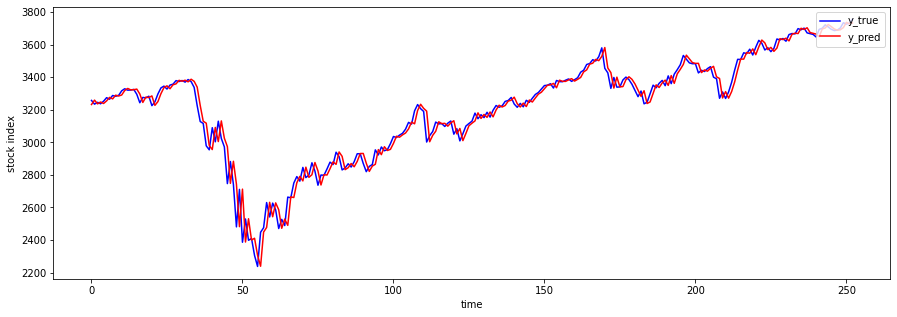

('MAE', 40.3758)

In [ ]:
stackpred_list=np.mean(testpred_record,axis=0)
pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                         dim_days=10,dim_emb=4,dim_CLSemb=7,dim_lstm=2,dim_fully=4,
                         epoch_num=10,lr=0.0016)

#============================================================================
arr=np.array(load_stockindex_('^GSPC')).reshape(-1)

stackpred_,pred_,true_=[],[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
    stackpred_.append(np.exp(stackpred_list[i])*arr[-len(test_y)-1+i])
print('==================S&P 500 2020.01.01 to 2020.12.31====================')
eval_(pred_,true_) 
#eval_(arr[-len(test_y):],true_) # check formula

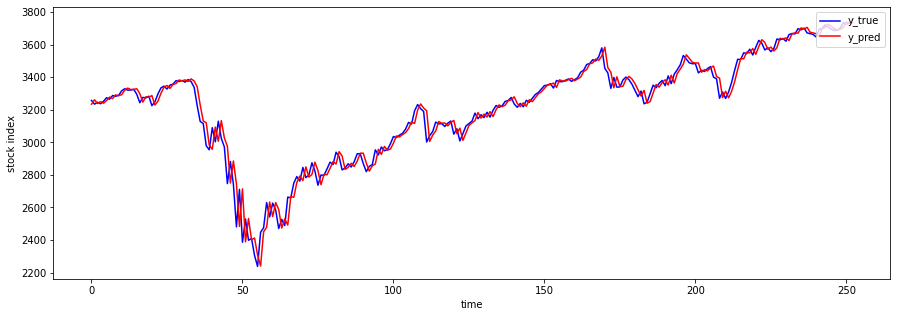

('MAE', 40.1948)

In [ ]:
eval_(stackpred_,true_)

## 1.2 RNN(index+CLS)

holdout_x1 shape= (1248, 10, 4)    test_x1 shape= (253, 10, 4)
holdout_x2 shape= (1248, 10, 9)    test_x2 shape= (253, 10, 9)
holdout_y shape= (1248,)    test_y shape= (253,)
validation 0  epoch loss= [0.009047 0.006486 0.006526 0.006635 0.006561 0.00651  0.006554 0.006465
 0.006491 0.006494]
validation 1  epoch loss= [0.010242 0.007465 0.007469 0.00735  0.007417 0.007383 0.007444 0.007344
 0.00737  0.007505]
validation 2  epoch loss= [0.009334 0.006445 0.006447 0.006447 0.006447 0.006447 0.006447 0.006447
 0.006447 0.006447]
validation 3  epoch loss= [0.017643 0.007916 0.007863 0.007888 0.007856 0.00781  0.007795 0.007904
 0.007943 0.007805]
validation 4  epoch loss= [0.00906  0.006583 0.006793 0.006829 0.006625 0.006988 0.00661  0.006638
 0.006622 0.006705]
validation 5  epoch loss= [0.007149 0.006562 0.006864 0.006457 0.006591 0.006528 0.006846 0.006637
 0.006683 0.006705]
validation 6  epoch loss= [0.008219 0.007417 0.00748  0.00742  0.007414 0.007498 0.007402 0.007467
 0.007592 0.

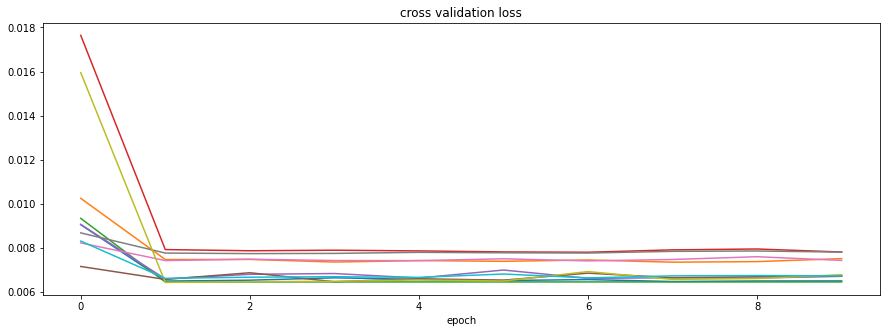

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^GSPC',emb_name='CLS',dim_days=10,dim_emb=4,dim_CLSemb=9)

cv_index_dict=cv_index_dict_(holdout_y)

valiloss_record, testpred_record=\
rnn_TUN_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,cv_index_dict,
         dim_days=10,dim_emb=4,dim_CLSemb=9,dim_lstm=2,dim_fully=4,
         epoch_num=10,lr=0.0016)

vis_valiloss_(valiloss_record)

==================S&P 500 2020.01.01 to 2020.12.31====================


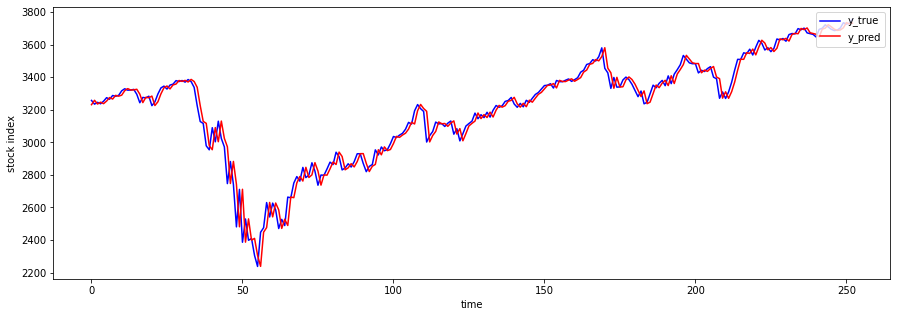

('MAE', 40.4967)

In [ ]:
stackpred_list=np.mean(testpred_record,axis=0)
pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                         dim_days=10,dim_emb=4,dim_CLSemb=9,dim_lstm=2,dim_fully=4,
                         epoch_num=10,lr=0.0016)

#============================================================================
arr=np.array(load_stockindex_('^GSPC')).reshape(-1)

stackpred_,pred_,true_=[],[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
    stackpred_.append(np.exp(stackpred_list[i])*arr[-len(test_y)-1+i])
print('==================S&P 500 2020.01.01 to 2020.12.31====================')
eval_(pred_,true_) 
#eval_(arr[-len(test_y):],true_) # check formula

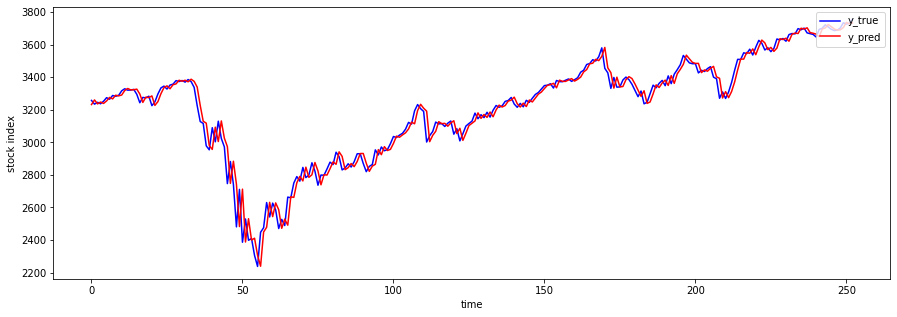

('MAE', 40.3339)

In [ ]:
eval_(stackpred_,true_)

# 2.Dow Jones Industrial

## 2.1 RNN(index+sentiment)

holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)
validation 0  epoch loss= [0.006815 0.006917 0.006973 0.006819 0.006978 0.006915 0.006973 0.006819
 0.006978 0.006915]
validation 1  epoch loss= [0.007398 0.007437 0.00759  0.007555 0.007507 0.00759  0.007555 0.007507
 0.00759  0.007555]
validation 2  epoch loss= [0.006853 0.007327 0.007065 0.007322 0.007065 0.007322 0.007065 0.007322
 0.007065 0.007322]
validation 3  epoch loss= [0.008424 0.008738 0.008422 0.008593 0.00843  0.008614 0.008389 0.008593
 0.00843  0.008614]
validation 4  epoch loss= [0.006875 0.006969 0.006874 0.006845 0.006845 0.006845 0.006845 0.006845
 0.006845 0.006845]
validation 5  epoch loss= [0.006857 0.007384 0.007309 0.007413 0.007309 0.007413 0.007309 0.007413
 0.007309 0.007413]
validation 6  epoch loss= [0.007387 0.00754  0.007457 0.007538 0.007457 0.007538 0.007457 0.007538
 0.007457 

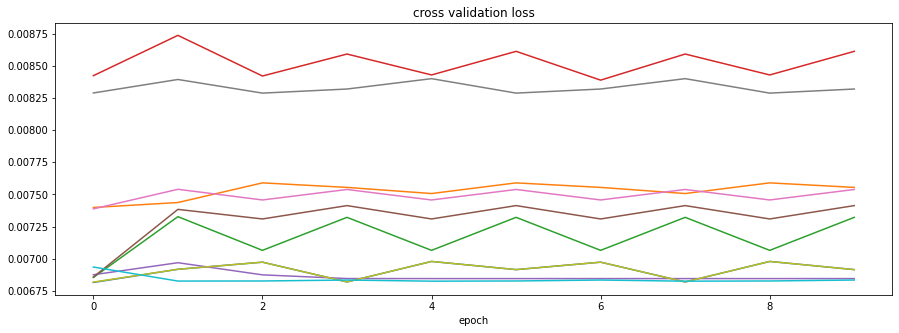

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^DJI',emb_name='sen',dim_days=10,dim_emb=15,dim_CLSemb=7)

cv_index_dict=cv_index_dict_(holdout_y)

valiloss_record, testpred_record=\
rnn_TUN_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,cv_index_dict,
         dim_days=10,dim_emb=15,dim_CLSemb=7,dim_lstm=10,dim_fully=4,
         epoch_num=10,lr=0.0016)

vis_valiloss_(valiloss_record)

==================Dow Jones Industrial 2020.01.01 to 2020.12.31====================


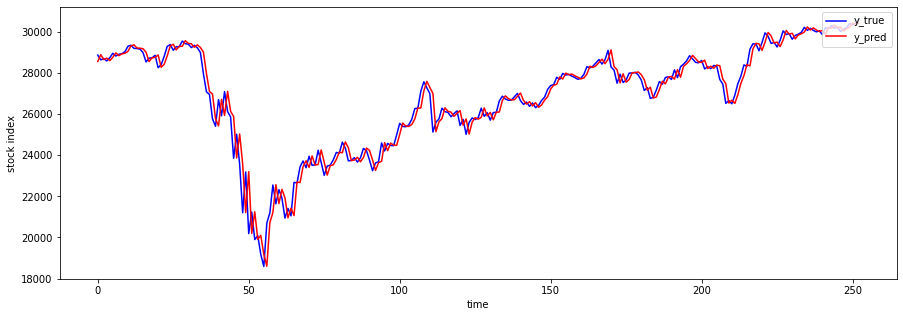

('MAE', 355.8394)

In [ ]:
stackpred_list=np.mean(testpred_record,axis=0)
pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                         dim_days=10,dim_emb=15,dim_CLSemb=7,dim_lstm=10,dim_fully=4,
                         epoch_num=10,lr=0.0016)

#============================================================================
arr=np.array(load_stockindex_('^DJI')).reshape(-1)

stackpred_,pred_,true_=[],[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
    stackpred_.append(np.exp(stackpred_list[i])*arr[-len(test_y)-1+i])
print('==================Dow Jones Industrial 2020.01.01 to 2020.12.31====================')
eval_(pred_,true_) 
#eval_(arr[-len(test_y):],true_) # check formula

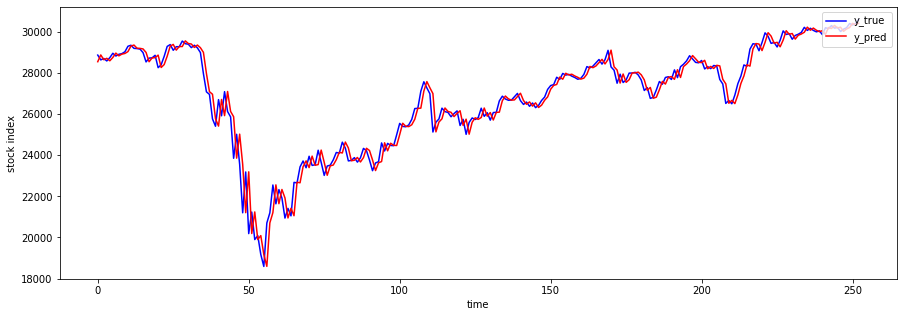

('MAE', 356.5082)

In [ ]:
eval_(stackpred_,true_)

## 2.2 RNN(index+CLS)

holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)
validation 0  epoch loss= [0.00694  0.007097 0.006831 0.007074 0.006831 0.007074 0.006831 0.007074
 0.006831 0.007074]
validation 1  epoch loss= [0.007577 0.007681 0.007536 0.007564 0.007552 0.007563 0.007552 0.007564
 0.007552 0.007564]
validation 2  epoch loss= [0.007651 0.00707  0.006923 0.007313 0.00735  0.006991 0.00764  0.007159
 0.007    0.007698]
validation 3  epoch loss= [0.008827 0.008526 0.008541 0.008379 0.00852  0.008573 0.008454 0.008481
 0.008473 0.008481]
validation 4  epoch loss= [0.006994 0.006897 0.006961 0.006859 0.00696  0.006859 0.00696  0.006859
 0.00696  0.006859]
validation 5  epoch loss= [0.00983  0.006884 0.007499 0.007038 0.007484 0.007259 0.007265 0.007484
 0.007259 0.007265]
validation 6  epoch loss= [0.010603 0.007521 0.007383 0.007451 0.007455 0.007515 0.007483 0.007385
 0.00745  

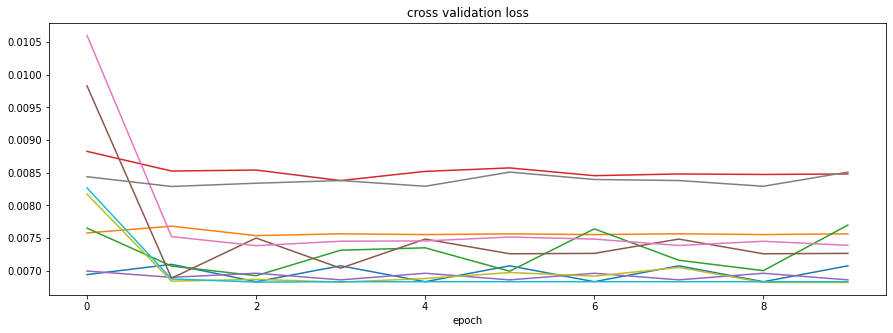

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^DJI',emb_name='CLS',dim_days=10,dim_emb=15,dim_CLSemb=7)

cv_index_dict=cv_index_dict_(holdout_y)

valiloss_record, testpred_record=\
rnn_TUN_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,cv_index_dict,
         dim_days=10,dim_emb=15,dim_CLSemb=7,dim_lstm=10,dim_fully=4,
         epoch_num=10,lr=0.0016)

vis_valiloss_(valiloss_record)

==================Dow Jones Industrial 2020.01.01 to 2020.12.31====================


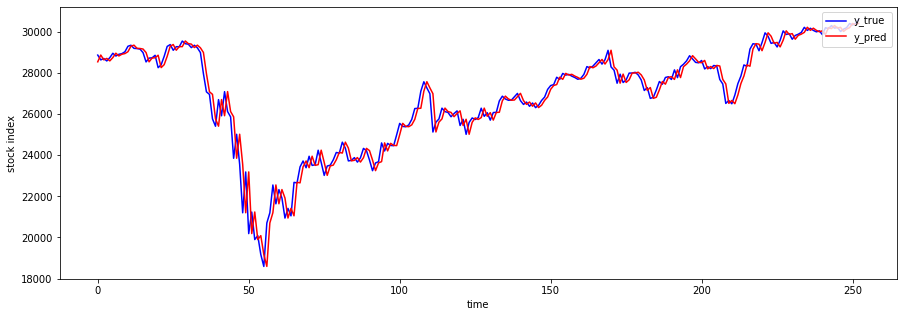

('MAE', 356.9525)

In [ ]:
stackpred_list=np.mean(testpred_record,axis=0)
pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                         dim_days=10,dim_emb=15,dim_CLSemb=7,dim_lstm=10,dim_fully=4,
                         epoch_num=10,lr=0.0016)

#============================================================================
arr=np.array(load_stockindex_('^DJI')).reshape(-1)

stackpred_,pred_,true_=[],[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
    stackpred_.append(np.exp(stackpred_list[i])*arr[-len(test_y)-1+i])
print('==================Dow Jones Industrial 2020.01.01 to 2020.12.31====================')
eval_(pred_,true_) 
#eval_(arr[-len(test_y):],true_) # check formula

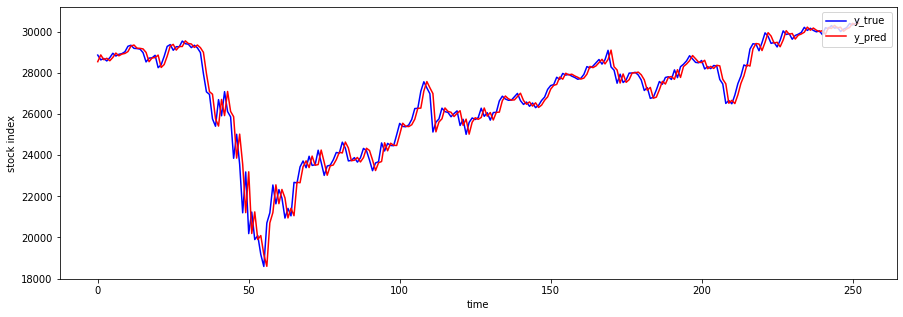

('MAE', 356.3773)

In [ ]:
eval_(stackpred_,true_)

# 3.Nasdaq Composite

## 3.1 RNN(index+sentiment)

holdout_x1 shape= (1248, 10, 4)    test_x1 shape= (253, 10, 4)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)
validation 0  epoch loss= [0.0086   0.008609 0.008695 0.009035 0.008725 0.008725 0.008725 0.008725
 0.008725 0.008725]
validation 1  epoch loss= [0.009601 0.009842 0.009648 0.009844 0.009648 0.009844 0.009648 0.009844
 0.009648 0.009844]
validation 2  epoch loss= [0.008585 0.008895 0.009184 0.008457 0.008477 0.00883  0.008895 0.009184
 0.008457 0.008477]
validation 3  epoch loss= [0.009799 0.009797 0.009872 0.009796 0.009872 0.009796 0.009872 0.009796
 0.009872 0.009796]
validation 4  epoch loss= [0.008944 0.008758 0.009271 0.008803 0.008769 0.008758 0.009271 0.008803
 0.008769 0.008758]
validation 5  epoch loss= [0.008489 0.009445 0.008491 0.009129 0.009076 0.009076 0.009076 0.009076
 0.009076 0.009076]
validation 6  epoch loss= [0.009769 0.009712 0.009714 0.00977  0.009848 0.009747 0.009712 0.009769
 0.009989 0.

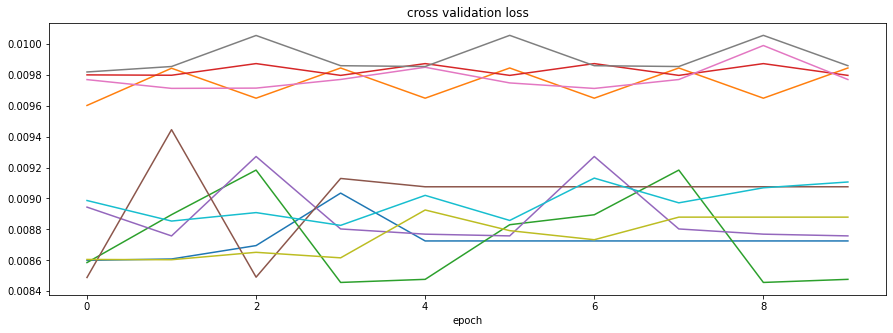

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^IXIC',emb_name='sen',dim_days=10,dim_emb=4,dim_CLSemb=7)

cv_index_dict=cv_index_dict_(holdout_y)

valiloss_record, testpred_record=\
rnn_TUN_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,cv_index_dict,
         dim_days=10,dim_emb=4,dim_CLSemb=7,dim_lstm=2,dim_fully=4,
         epoch_num=10,lr=0.0016)

vis_valiloss_(valiloss_record)

==================Nasdaq Composite 2020.01.01 to 2020.12.31====================


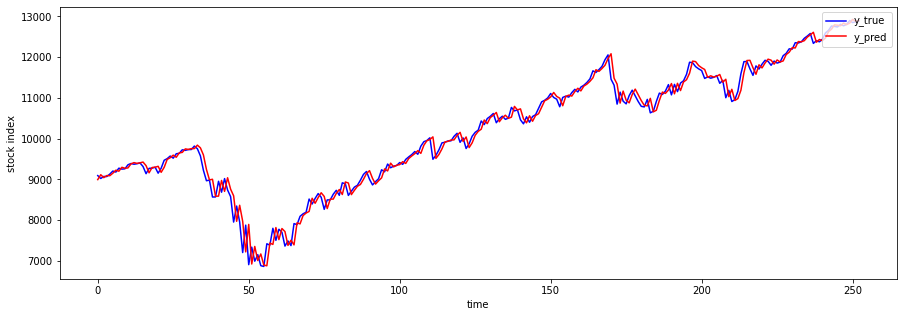

('MAE', 136.1145)

In [ ]:
stackpred_list=np.mean(testpred_record,axis=0)
pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                         dim_days=10,dim_emb=4,dim_CLSemb=7,dim_lstm=2,dim_fully=4,
                         epoch_num=10,lr=0.0016)

#============================================================================
arr=np.array(load_stockindex_('^IXIC')).reshape(-1)

stackpred_,pred_,true_=[],[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
    stackpred_.append(np.exp(stackpred_list[i])*arr[-len(test_y)-1+i])
print('==================Nasdaq Composite 2020.01.01 to 2020.12.31====================')
eval_(pred_,true_) 
#eval_(arr[-len(test_y):],true_) # check formula

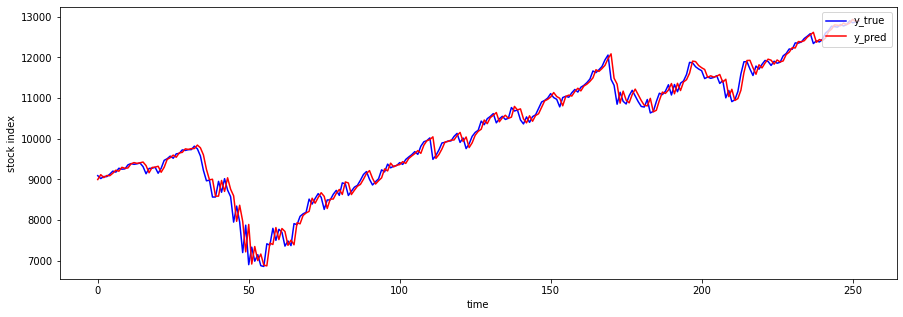

('MAE', 135.9231)

In [ ]:
eval_(stackpred_,true_)

## 3.2 RNN(index+CLS)

holdout_x1 shape= (1248, 10, 4)    test_x1 shape= (253, 10, 4)
holdout_x2 shape= (1248, 10, 9)    test_x2 shape= (253, 10, 9)
holdout_y shape= (1248,)    test_y shape= (253,)
validation 0  epoch loss= [0.013508 0.008631 0.008636 0.008639 0.00863  0.008623 0.008999 0.008634
 0.00887  0.008641]
validation 1  epoch loss= [0.009569 0.009745 0.009826 0.009745 0.009536 0.009758 0.010316 0.00958
 0.009659 0.009589]
validation 2  epoch loss= [0.009371 0.008473 0.008466 0.008527 0.008444 0.008409 0.008862 0.008669
 0.008408 0.008505]
validation 3  epoch loss= [0.011612 0.009832 0.009783 0.009838 0.009858 0.009867 0.009817 0.009826
 0.009919 0.009829]
validation 4  epoch loss= [0.010235 0.008966 0.008749 0.008843 0.009167 0.008991 0.008978 0.009288
 0.008957 0.008833]
validation 5  epoch loss= [0.009409 0.008971 0.009022 0.00881  0.008722 0.008914 0.009046 0.008908
 0.008935 0.009161]
validation 6  epoch loss= [0.015923 0.009724 0.00972  0.00997  0.010617 0.010008 0.009975 0.010382
 0.010007 0.0

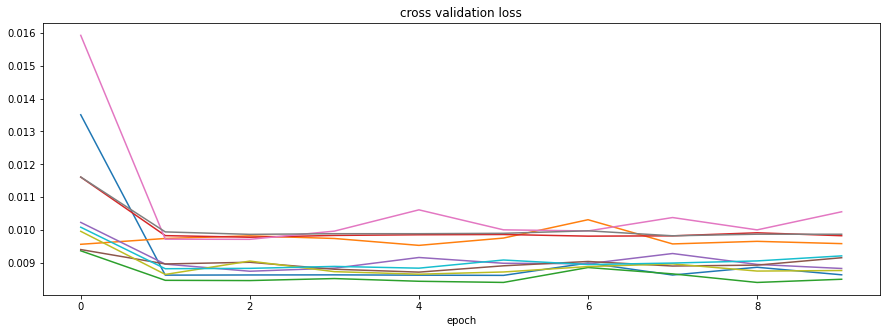

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^IXIC',emb_name='CLS',dim_days=10,dim_emb=4,dim_CLSemb=9)

cv_index_dict=cv_index_dict_(holdout_y)

valiloss_record, testpred_record=\
rnn_TUN_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,cv_index_dict,
         dim_days=10,dim_emb=4,dim_CLSemb=9,dim_lstm=2,dim_fully=4,
         epoch_num=10,lr=0.0016)

vis_valiloss_(valiloss_record)

==================Nasdaq Composite 2020.01.01 to 2020.12.31====================


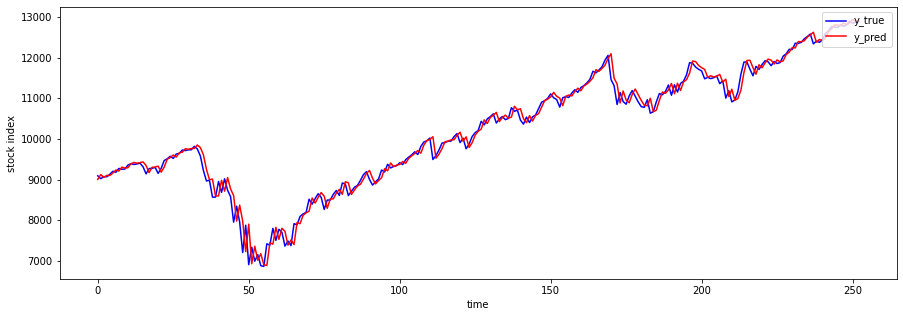

('MAE', 135.4511)

In [ ]:
stackpred_list=np.mean(testpred_record,axis=0)
pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                         dim_days=10,dim_emb=4,dim_CLSemb=9,dim_lstm=2,dim_fully=4,
                         epoch_num=10,lr=0.0016)

#============================================================================
arr=np.array(load_stockindex_('^IXIC')).reshape(-1)

stackpred_,pred_,true_=[],[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
    stackpred_.append(np.exp(stackpred_list[i])*arr[-len(test_y)-1+i])
print('==================Nasdaq Composite 2020.01.01 to 2020.12.31====================')
eval_(pred_,true_) 
#eval_(arr[-len(test_y):],true_) # check formula

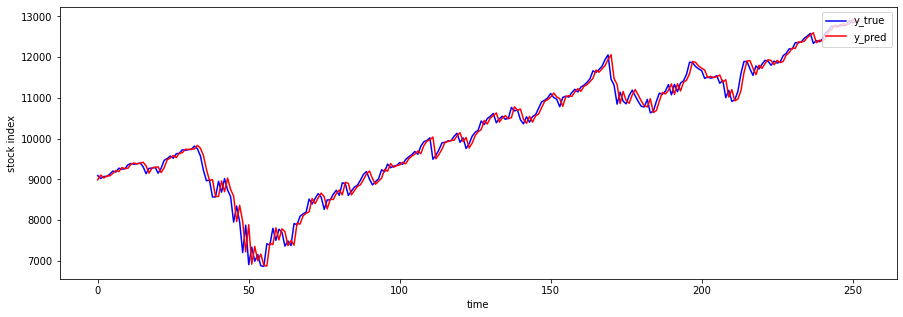

('MAE', 137.4961)

In [ ]:
eval_(stackpred_,true_)

# sub

## explore uncertainty

### S&P 500

holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)
holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


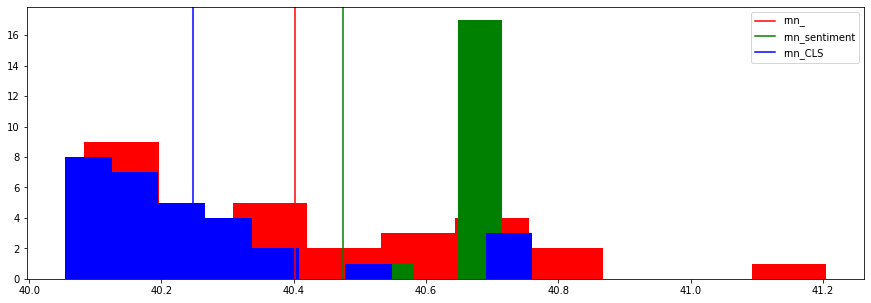

In [ ]:
num_samples=30

v_index_name='^GSPC'
v_epoch_num=4
v_lr=0.0016

v_dim_days=10
v_dim_emb=15
v_dim_CLSemb=7
v_dim_lstm=10
v_dim_fully=4

#===================================================================
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name=v_index_name,emb_name='sen',dim_days=v_dim_days,dim_emb=v_dim_emb)

holdout_x1,test_x1,holdout_xx2,test_xx2,holdout_y,test_y=\
generate_samples(index_name=v_index_name,emb_name='CLS',dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=v_dim_CLSemb)

arr=np.array(load_stockindex_(v_index_name)).reshape(-1)

#====================================================================
rnn_mae,rnn_senemb_mae,rnn_clsemb_mae=[],[],[]
for j in range(num_samples):
  #rnn
  pred_list,true_list=subrnn_(holdout_x1,test_x1,holdout_y,test_y,
                              epoch_num=v_epoch_num,
                              dim_days=v_dim_days,dim_emb=v_dim_emb,dim_lstm=v_dim_lstm)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_mae.append(eval_(pred_,true_,vis=False)[1])
  
  #rnn_sentiment
  pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                           dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=7,dim_lstm=v_dim_lstm,dim_fully=v_dim_fully,
                           epoch_num=v_epoch_num,lr=v_lr)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_senemb_mae.append(eval_(pred_,true_,vis=False)[1])

  #rnn_cls
  pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_xx2,test_xx2,holdout_y,test_y,
                          dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=v_dim_CLSemb,dim_lstm=v_dim_lstm,dim_fully=v_dim_fully,
                          epoch_num=v_epoch_num,lr=v_lr)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_clsemb_mae.append(eval_(pred_,true_,vis=False)[1]) 

  #===============================================================
vis_uncertainty_(rnn_mae,rnn_senemb_mae,rnn_clsemb_mae)

### Dow Jones

holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)
holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


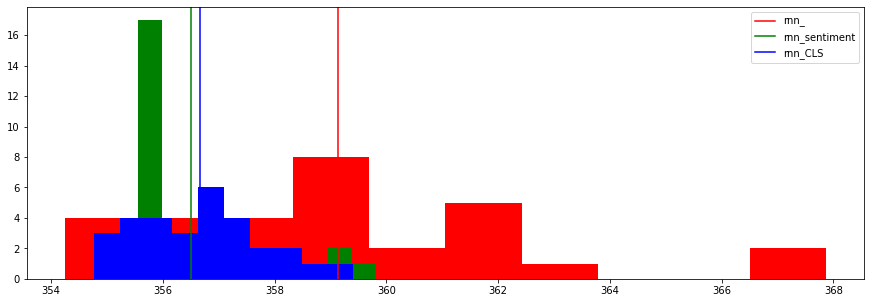

In [ ]:
num_samples=30

v_index_name='^DJI'
v_epoch_num=4
v_lr=0.0016

v_dim_days=10
v_dim_emb=15
v_dim_CLSemb=7
v_dim_lstm=10
v_dim_fully=4

#===================================================================
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name=v_index_name,emb_name='sen',dim_days=v_dim_days,dim_emb=v_dim_emb)

holdout_x1,test_x1,holdout_xx2,test_xx2,holdout_y,test_y=\
generate_samples(index_name=v_index_name,emb_name='CLS',dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=v_dim_CLSemb)

arr=np.array(load_stockindex_(v_index_name)).reshape(-1)

#====================================================================
rnn_mae,rnn_senemb_mae,rnn_clsemb_mae=[],[],[]
for j in range(num_samples):
  #rnn
  pred_list,true_list=subrnn_(holdout_x1,test_x1,holdout_y,test_y,
                              epoch_num=v_epoch_num,
                              dim_days=v_dim_days,dim_emb=v_dim_emb,dim_lstm=v_dim_lstm)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_mae.append(eval_(pred_,true_,vis=False)[1])
  
  #rnn_sentiment
  pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                           dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=7,dim_lstm=v_dim_lstm,dim_fully=v_dim_fully,
                           epoch_num=v_epoch_num,lr=v_lr)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_senemb_mae.append(eval_(pred_,true_,vis=False)[1])

  #rnn_cls
  pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_xx2,test_xx2,holdout_y,test_y,
                          dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=v_dim_CLSemb,dim_lstm=v_dim_lstm,dim_fully=v_dim_fully,
                          epoch_num=v_epoch_num,lr=v_lr)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_clsemb_mae.append(eval_(pred_,true_,vis=False)[1]) 

  #===============================================================
vis_uncertainty_(rnn_mae,rnn_senemb_mae,rnn_clsemb_mae)

### Nasdaq

holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)
holdout_x1 shape= (1248, 10, 15)    test_x1 shape= (253, 10, 15)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


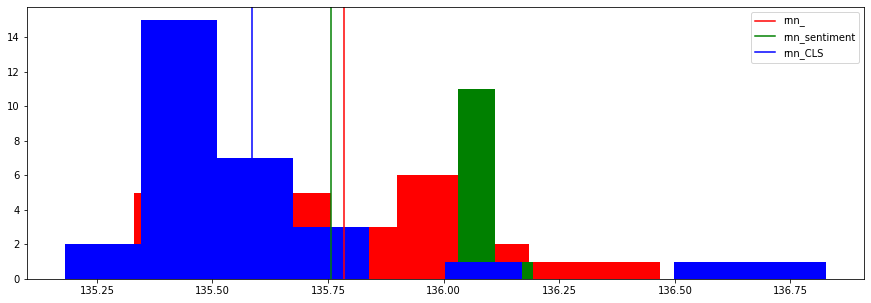

In [ ]:
num_samples=30

v_index_name='^IXIC'
v_epoch_num=4
v_lr=0.0016

v_dim_days=10
v_dim_emb=15
v_dim_CLSemb=7
v_dim_lstm=10
v_dim_fully=4

#===================================================================
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name=v_index_name,emb_name='sen',dim_days=v_dim_days,dim_emb=v_dim_emb)

holdout_x1,test_x1,holdout_xx2,test_xx2,holdout_y,test_y=\
generate_samples(index_name=v_index_name,emb_name='CLS',dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=v_dim_CLSemb)

arr=np.array(load_stockindex_(v_index_name)).reshape(-1)

#====================================================================
rnn_mae,rnn_senemb_mae,rnn_clsemb_mae=[],[],[]
for j in range(num_samples):
  #rnn
  pred_list,true_list=subrnn_(holdout_x1,test_x1,holdout_y,test_y,
                              epoch_num=v_epoch_num,
                              dim_days=v_dim_days,dim_emb=v_dim_emb,dim_lstm=v_dim_lstm)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_mae.append(eval_(pred_,true_,vis=False)[1])
  
  #rnn_sentiment
  pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y,
                           dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=7,dim_lstm=v_dim_lstm,dim_fully=v_dim_fully,
                           epoch_num=v_epoch_num,lr=v_lr)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_senemb_mae.append(eval_(pred_,true_,vis=False)[1])

  #rnn_cls
  pred_list,true_list=rnn_(holdout_x1,test_x1,holdout_xx2,test_xx2,holdout_y,test_y,
                          dim_days=v_dim_days,dim_emb=v_dim_emb,dim_CLSemb=v_dim_CLSemb,dim_lstm=v_dim_lstm,dim_fully=v_dim_fully,
                          epoch_num=v_epoch_num,lr=v_lr)
  pred_,true_=[],[]
  for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])
  rnn_clsemb_mae.append(eval_(pred_,true_,vis=False)[1]) 

  #===============================================================
vis_uncertainty_(rnn_mae,rnn_senemb_mae,rnn_clsemb_mae)

## predict power (historical market index)

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


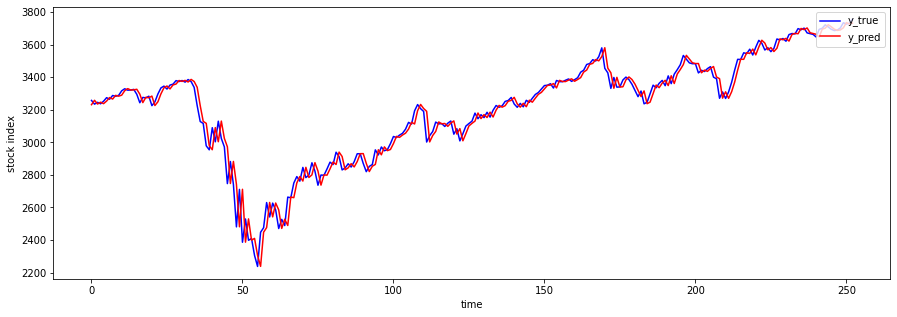

('MAE', 40.4997)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^GSPC',emb_name='sen',dim_days=10,dim_emb=3)

pred_list,true_list=subrnn_(holdout_x1,test_x1,holdout_y,test_y,
                            epoch_num=10,
                            dim_days=10,dim_emb=3,dim_lstm=2)

arr=np.array(load_stockindex_('^GSPC')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


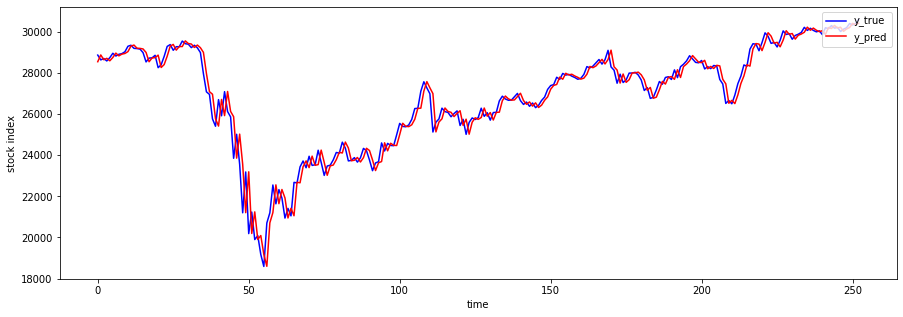

('MAE', 356.5247)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^DJI',emb_name='sen',dim_days=10,dim_emb=3)

pred_list,true_list=subrnn_(holdout_x1,test_x1,holdout_y,test_y,
                            epoch_num=10,
                            dim_days=10,dim_emb=3,dim_lstm=2)

arr=np.array(load_stockindex_('^DJI')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_)

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


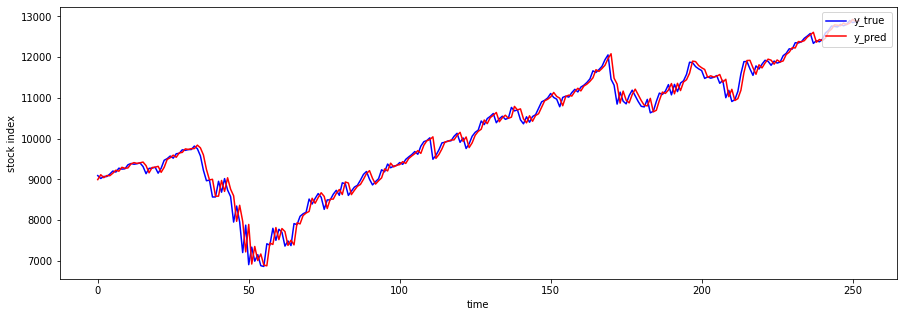

('MAE', 136.1253)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^IXIC',emb_name='sen',dim_days=10,dim_emb=3)

pred_list,true_list=subrnn_(holdout_x1,test_x1,holdout_y,test_y,
                            epoch_num=10,
                            dim_days=10,dim_emb=3,dim_lstm=2)

arr=np.array(load_stockindex_('^IXIC')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 

## predict power (sentiment)

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


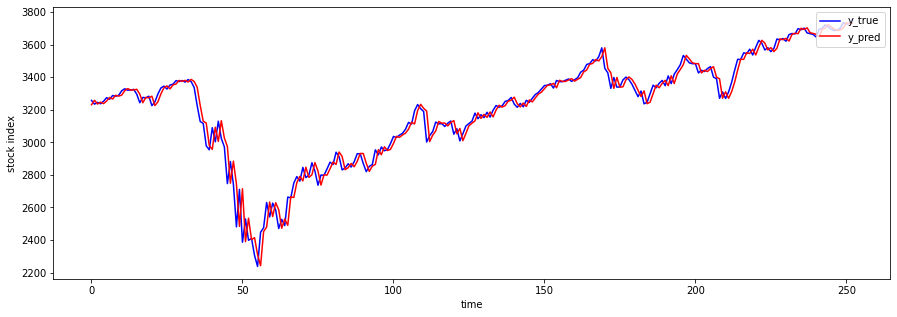

('MAE', 40.4541)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^GSPC',emb_name='sen',dim_days=10,dim_CLSemb=7)

pred_list,true_list=subrnn_(holdout_x2,test_x2,holdout_y,test_y,
                         epoch_num=10,
                         dim_days=10,dim_emb=7,dim_lstm=2)

arr=np.array(load_stockindex_('^GSPC')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


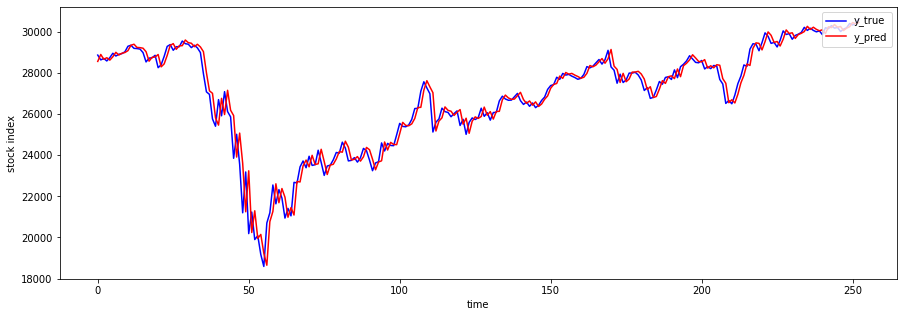

('MAE', 354.9724)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^DJI',emb_name='sen',dim_days=10,dim_CLSemb=7)

pred_list,true_list=subrnn_(holdout_x2,test_x2,holdout_y,test_y,
                         epoch_num=10,
                         dim_days=10,dim_emb=7,dim_lstm=2)

arr=np.array(load_stockindex_('^DJI')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 7)    test_x2 shape= (253, 10, 7)
holdout_y shape= (1248,)    test_y shape= (253,)


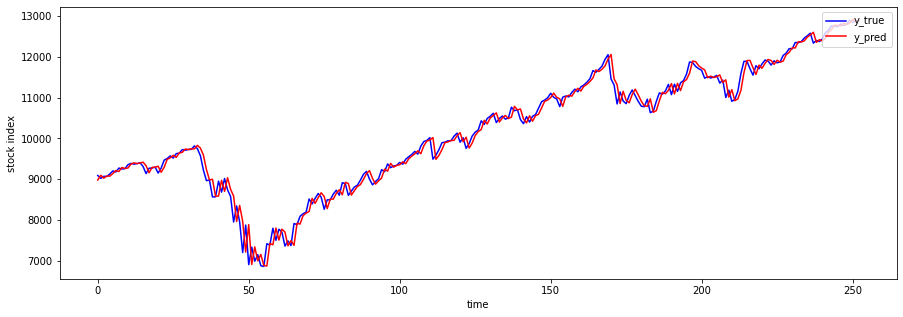

('MAE', 137.6051)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^IXIC',emb_name='sen',dim_days=10,dim_CLSemb=7)

pred_list,true_list=subrnn_(holdout_x2,test_x2,holdout_y,test_y,
                         epoch_num=10,
                         dim_days=10,dim_emb=7,dim_lstm=2)

arr=np.array(load_stockindex_('^IXIC')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 

## predict power (CLS)

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 9)    test_x2 shape= (253, 10, 9)
holdout_y shape= (1248,)    test_y shape= (253,)


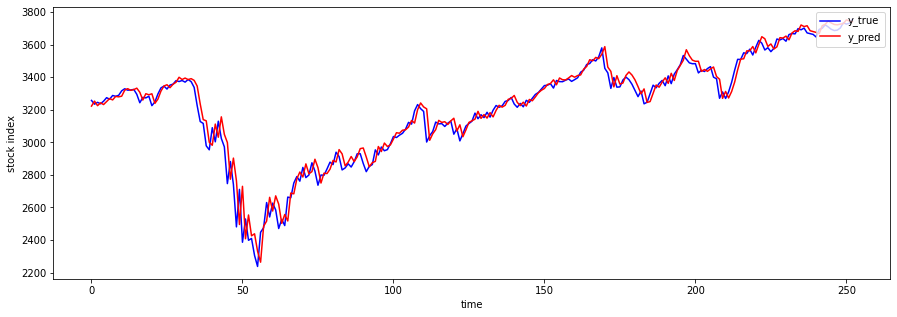

('MAE', 42.0826)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^GSPC',emb_name='CLS',dim_days=10,dim_CLSemb=9)

pred_list,true_list=subrnn_(holdout_x2,test_x2,holdout_y,test_y,
                         epoch_num=10,
                         dim_days=10,dim_emb=9,dim_lstm=2)

arr=np.array(load_stockindex_('^GSPC')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 9)    test_x2 shape= (253, 10, 9)
holdout_y shape= (1248,)    test_y shape= (253,)


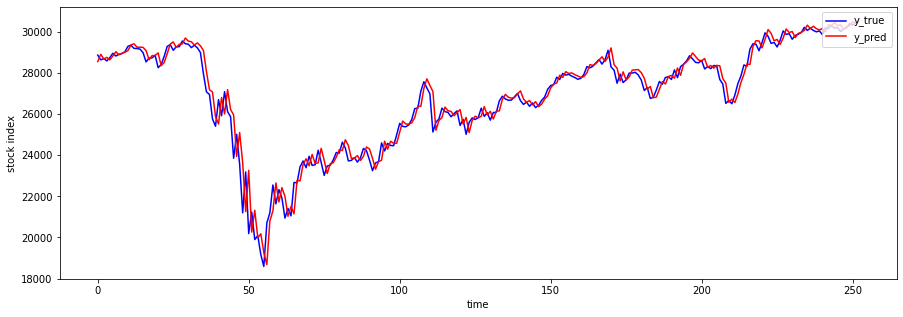

('MAE', 360.6626)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^DJI',emb_name='CLS',dim_days=10,dim_CLSemb=9)

pred_list,true_list=subrnn_(holdout_x2,test_x2,holdout_y,test_y,
                         epoch_num=10,
                         dim_days=10,dim_emb=9,dim_lstm=2)

arr=np.array(load_stockindex_('^DJI')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 

holdout_x1 shape= (1248, 10, 3)    test_x1 shape= (253, 10, 3)
holdout_x2 shape= (1248, 10, 9)    test_x2 shape= (253, 10, 9)
holdout_y shape= (1248,)    test_y shape= (253,)


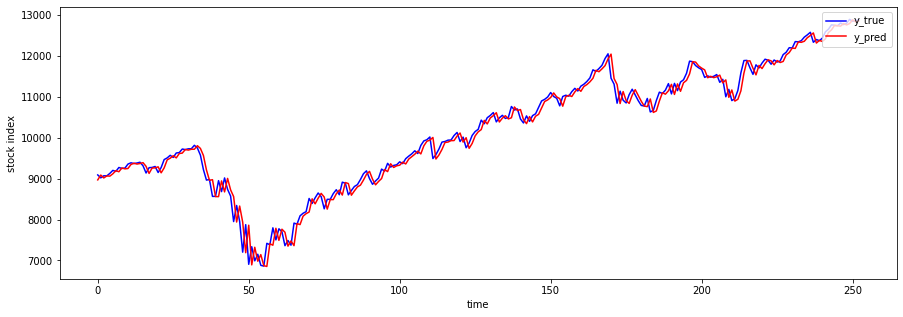

('MAE', 143.1657)

In [ ]:
holdout_x1,test_x1,holdout_x2,test_x2,holdout_y,test_y=\
generate_samples(index_name='^IXIC',emb_name='CLS',dim_days=10,dim_CLSemb=9)

pred_list,true_list=subrnn_(holdout_x2,test_x2,holdout_y,test_y,
                         epoch_num=10,
                         dim_days=10,dim_emb=9,dim_lstm=2)

arr=np.array(load_stockindex_('^IXIC')).reshape(-1)
pred_,true_=[],[]
for i in range(len(test_y)):
    true_.append(np.exp(true_list[i])*arr[-len(test_y)-1+i])
    pred_.append(np.exp(pred_list[i])*arr[-len(test_y)-1+i])

eval_(pred_,true_) 